In this notebook, we'll use the following techniques to train a state-of-the-art model in classifying images from the Blindness dataset:

- Data normalization
- Data augmentation
- Residual connections
- Batch normalization
- Learning rate scheduling
- Weight Decay
- Gradient clipping
- Adam optimizer

## Importing the required libraries

In [1]:
import os
import torch
import torchvision
import pandas as pd
import torch.nn as nn
from PIL import Image
import cv2
import numpy as np
import torch.nn.functional as F
import torchvision.transforms as tt
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.models as models # Pre-Trained models
import sklearn
from sklearn.metrics import cohen_kappa_score, accuracy_score
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [2]:
data_dir = "../input/aptos2019-blindness-detection/"
print(os.listdir("../input/aptos2019-blindness-detection"))

['sample_submission.csv', 'train_images', 'train.csv', 'test.csv', 'test_images']


## Loading Dataset + EDA

In [3]:
train_csv = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
test_csv = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')

In [4]:
print('Train Size = {}'.format(len(train_csv)))
print('Public Test Size = {}'.format(len(test_csv)))

Train Size = 3662
Public Test Size = 1928


In [5]:
train_csv.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [6]:
test_csv.head()

,id_code
0,0005cfc8afb6
1,003f0afdcd15
2,006efc72b638
3,00836aaacf06
4,009245722fa4


In [7]:
test_csv['diagnosis'] = -1

In [8]:
test_csv.head()

,id_code,diagnosis
0,0005cfc8afb6,-1
1,003f0afdcd15,-1
2,006efc72b638,-1
3,00836aaacf06,-1
4,009245722fa4,-1


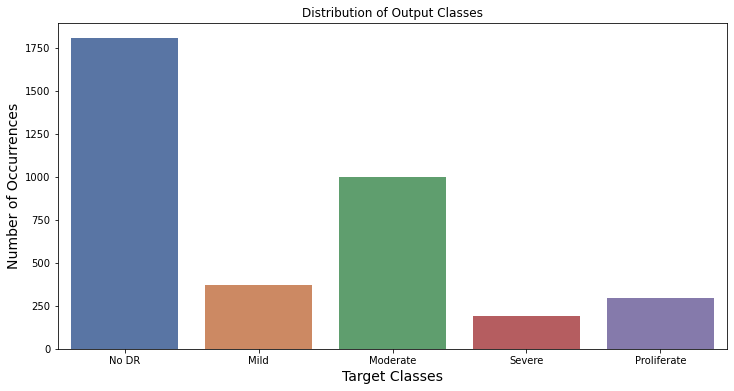

In [9]:
import seaborn as sns

counts = train_csv['diagnosis'].value_counts()
class_list = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferate']
for i,x in enumerate(class_list):
    counts[x] = counts.pop(i)

plt.figure(figsize=(12,6))
sns.barplot(counts.index, counts.values, alpha=1, palette='deep')
plt.title('Distribution of Output Classes')
plt.ylabel('Number of Occurrences', fontsize=14)
plt.xlabel('Target Classes', fontsize=14)
plt.show()

## Visualizing Training Data

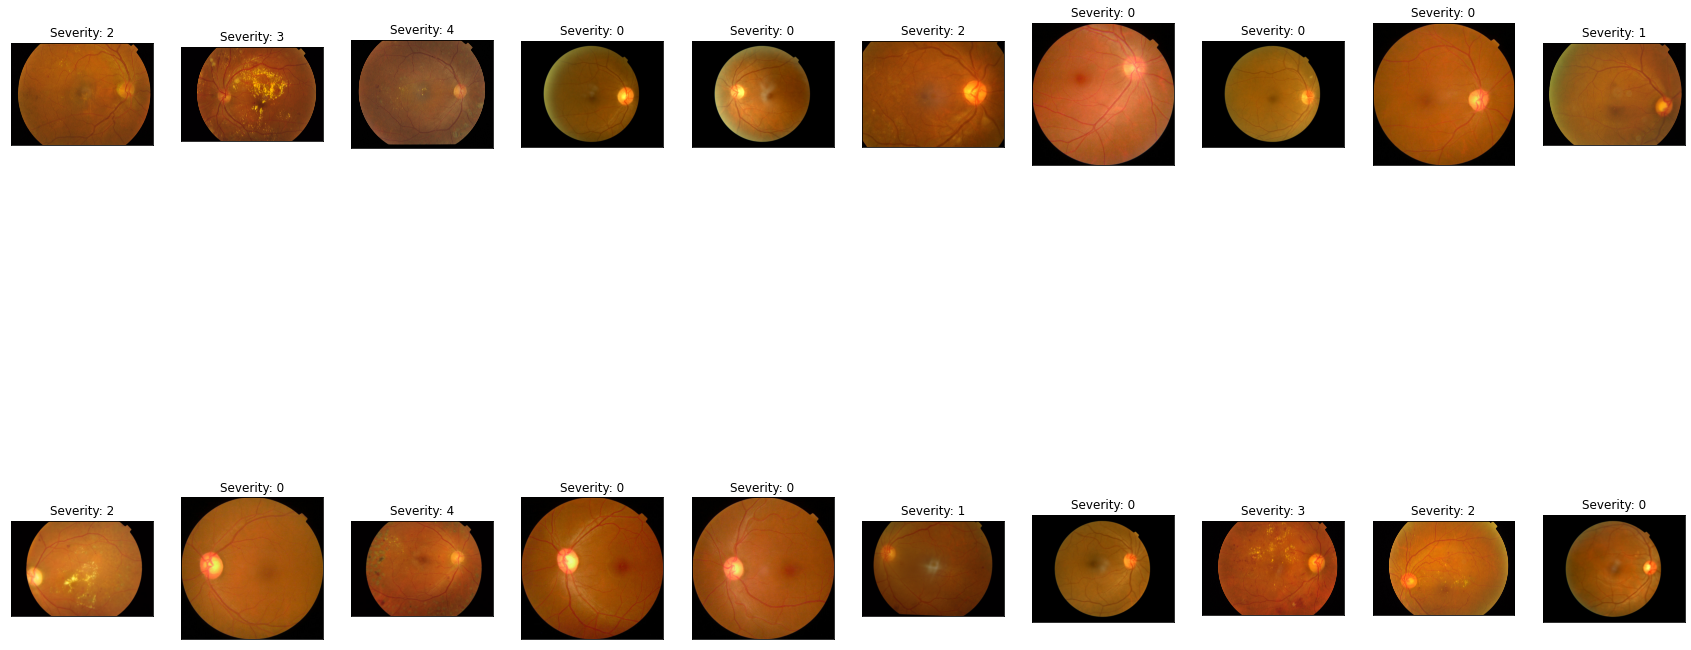

In [10]:
fig = plt.figure(figsize=(30, 16))
# display 20 images
train_imgs = os.listdir(data_dir+"/train_images")
for idx, img in enumerate(np.random.choice(train_imgs, 20)):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    im = Image.open(data_dir+"/train_images/" + img)
    plt.imshow(im)
    lab = train_csv.loc[train_csv['id_code'] == img.split('.')[0], 'diagnosis'].values[0]
    ax.set_title('Severity: %s'%lab)

## Data Preprocessing

In [11]:
# Data transforms (normalization & data augmentation)
stats = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
train_tfms = tt.Compose([tt.ToPILImage(mode='RGB'),
                         tt.Resize((224, 224)),
                         tt.RandomHorizontalFlip(),
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)])

valid_tfms = tt.Compose([tt.ToPILImage(mode='RGB'),
                         tt.Resize((224, 224)),
                         tt.ToTensor(),
                         tt.Normalize(*stats)])

In [12]:
# Our own custom class for datasets

from torch.utils.data import Dataset

class CreateDataset(Dataset):
    def __init__(self, df_data, data_dir = '../input/', transform=None):
        super().__init__()
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_name,label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name+'.png')
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [13]:
train_path = "../input/aptos2019-blindness-detection/train_images/"
test_path = "../input/aptos2019-blindness-detection/test_images/"

In [14]:
train_data = CreateDataset(df_data=train_csv, data_dir=train_path, transform=train_tfms)
test_data = CreateDataset(df_data=test_csv, data_dir=test_path, transform=valid_tfms)

In [15]:
# Percentage of training set to use as validation
valid_size = 0.15

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# Create Samplers
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [16]:
batch_size = 8

In [17]:
# PyTorch data loaders
train_dl = DataLoader(train_data, batch_size, sampler=train_sampler)
valid_dl = DataLoader(train_data, batch_size, sampler=valid_sampler)

In [18]:
len(train_dl)

390

In [19]:
len(valid_dl)

69

## Define Model Architecture

In [20]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Based on where you're running this notebook, your default device could be a CPU (`torch.device('cpu')`) or a GPU (`torch.device('cuda')`)

In [21]:
device = get_default_device()
device

device(type='cuda')

We can now wrap our training and validation data loaders using `DeviceDataLoader` for automatically transferring batches of data to the GPU.

In [22]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [23]:
torch.cuda.empty_cache()

In [24]:
import torch

In [25]:
a = torch.Tensor([3.56,4,0])

In [26]:
a

tensor([3.5600, 4.0000, 0.0000])

In [27]:
b = a.numpy()

In [28]:
b

array([3.56, 4.  , 0.  ], dtype=float32)

In [29]:
torch.from_numpy(b)

tensor([3.5600, 4.0000, 0.0000])

In [86]:
c = [[1,23,5,3,], [3,52,6,2]]

In [67]:
c = np.array(c)

In [68]:
torch.from_numpy(c)

tensor([ 1, 23,  5,  6,  7,  3])

In [87]:
v = torch.Tensor(c)

In [88]:
v

tensor([[ 1., 23.,  5.,  3.],
        [ 3., 52.,  6.,  2.]])

In [99]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = nn.SmoothL1Loss()(out, labels.float()) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = nn.SmoothL1Loss()(out, labels.float())   # Calculate loss
        out = out.cpu().numpy()
        labels = labels.cpu().numpy()
        kappa_score = cohen_kappa_score(out.round(), labels)           # Calculate score
        return {'val_loss': loss.detach(), 'val_kappa': kappa_score}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_kappas = [x['val_kappa'] for x in outputs]
        batch_kappas = torch.Tensor(batch_kappas)
        epoch_kappa = torch.stack(tuple(batch_kappas)).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_kappa': epoch_kappa.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_kappa: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_kappa']))

In [100]:
class BlindnessDetectorModel(ImageClassificationBase):
    def __init__(self, pretrained=False):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet152(pretrained=pretrained)
        # Replace last layer
        self.network.fc = nn.Sequential(
                nn.Linear(in_features=2048, out_features=1024, bias=True),
                nn.ReLU(),
                nn.Linear(in_features=1024, out_features=512, bias=True),
                nn.ReLU(),
                nn.Linear(in_features=512, out_features=256, bias=True),
                nn.ReLU(),
                nn.Linear(in_features=256, out_features=128, bias=True),
                nn.ReLU(),
                nn.Linear(in_features=128, out_features=32, bias=True),
                nn.ReLU(),
                nn.Linear(in_features=32, out_features=1, bias=True), 
            )

    def forward(self, xb):
        return self.network(xb)

In [101]:
model = to_device(BlindnessDetectorModel(), device)
model

BlindnessDetectorModel(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequent

In [102]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [103]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 900458.4375, 'val_kappa': 0.0}]

In [104]:
epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [105]:
%%time
history = fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/loss.py:822: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


Epoch [0], last_lr: 0.00395, train_loss: 0.6883, val_loss: 0.7247, val_kappa: -0.0257
Epoch [1], last_lr: 0.00936, train_loss: 0.6590, val_loss: 0.6893, val_kappa: 0.0000
Epoch [2], last_lr: 0.00972, train_loss: 0.6562, val_loss: 0.6762, val_kappa: 0.0000
Epoch [3], last_lr: 0.00812, train_loss: 0.6556, val_loss: 0.6810, val_kappa: 0.0000
Epoch [4], last_lr: 0.00556, train_loss: 0.6591, val_loss: 0.6765, val_kappa: 0.0000
Epoch [5], last_lr: 0.00283, train_loss: 0.6527, val_loss: 0.6783, val_kappa: 0.0000
Epoch [6], last_lr: 0.00077, train_loss: 0.6525, val_loss: 0.6798, val_kappa: 0.0000
Epoch [7], last_lr: 0.00000, train_loss: 0.6577, val_loss: 0.6796, val_kappa: 0.0000
CPU times: user 1h 1min 19s, sys: 1min 14s, total: 1h 2min 33s
Wall time: 1h 5min 47s


In [108]:
def plot_kappa(history):
    kappas = [x['val_kappa'] for x in history]
    plt.plot(kappas, '-x')
    plt.xlabel('epoch')
    plt.ylabel('kappa_score')
    plt.title('Accuracy vs. No. of epochs');

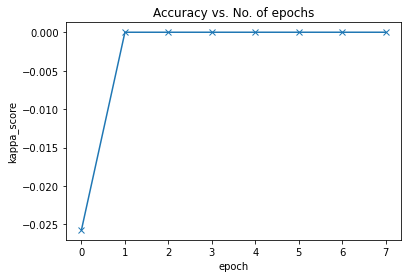

In [109]:
plot_kappa(history)

We can also plot the training and validation losses to study the trend.

In [110]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

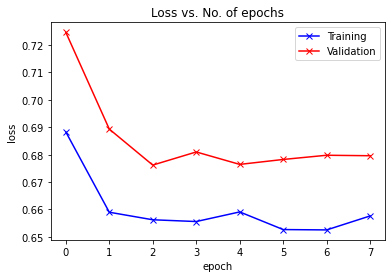

In [111]:
plot_losses(history)

As expected, the learning rate starts at a low value, and gradually increases for 30% of the iterations to a maximum value of `0.01`, and then gradually decreases to a very small value.

## Testing with individual images

While we have been tracking the overall accuracy of a model so far, it's also a good idea to look at model's results on some sample images. Let's test out our model with some images from the predefined test dataset of 10000 images.



In [128]:
 def round_off_preds(preds, coef=[0.5, 1.5, 2.5, 3.5]):
    for i, pred in enumerate(preds):
            if pred < coef[0]:
                preds[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                preds[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                preds[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                preds[i] = 3
            else:
                preds[i] = 4
    return preds

In [ ]:
class_list = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferate']

In [136]:
def predict_single_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    preds = int(round_off_preds(yb))
    # Retrieve the class label
    return class_list[preds]

Predicted: Mild


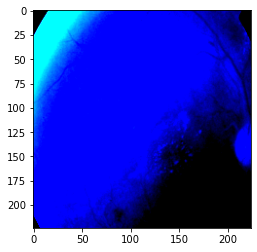

In [137]:
img, label = test_data[0]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Predicted:', predict_single_image(img, model))

In [139]:
def predict(testloader):
    '''Function used to make predictions on the test set'''
    model.eval()
    preds = []
    for batch_i, (data, target) in enumerate(testloader):
        data, target = data.cuda(), target.cuda()
        output = model(data)
        pr = output.detach().cpu().numpy()
        for i in pr:
            preds.append(i.item())
            
    return preds

In [138]:
test_dl = DataLoader(test_data, batch_size)

In [140]:
preds = np.array(predict(testloader=test_dl))

In [141]:
preds = round_off_preds(preds)

## Saving Predictions

In [142]:
sample_sub = pd.read_csv('../input/aptos2019-blindness-detection/sample_submission.csv')

In [143]:
sample_sub.diagnosis = preds
sample_sub.diagnosis = sample_sub['diagnosis'].astype(int)

In [144]:
sample_sub.head()

,id_code,diagnosis
0,0005cfc8afb6,1
1,003f0afdcd15,1
2,006efc72b638,1
3,00836aaacf06,1
4,009245722fa4,1


In [145]:
sample_sub.to_csv('submission.csv', index=False)

## Save and Commit

Let's save the weights of the model, record the hyperparameters, and commit our experiment to Jovian. As you try different ideas, make sure to record every experiment so you can look back and analyze the results.

In [146]:
torch.save(model.state_dict(), 'blindness-detector-resnet152.pth')

In [147]:
!pip install jovian --upgrade --quiet

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [148]:
import jovian

<IPython.core.display.Javascript object>

In [149]:
jovian.reset()
jovian.log_hyperparams(arch='resnet152', 
                       epochs=epochs, 
                       lr=max_lr, 
                       scheduler='one-cycle', 
                       weight_decay=weight_decay, 
                       grad_clip=grad_clip,
                       opt=opt_func.__name__)

[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ········
[jovian] Hyperparams logged.


In [152]:
train_time = '1:05:47'

In [153]:
jovian.log_metrics(val_loss=history[-1]['val_loss'], 
                   val_acc=history[-1]['val_kappa'],
                   train_loss=history[-1]['train_loss'],
                   time=train_time)

[jovian] Metrics logged.


In [155]:
project_name = 'Blindness-Detection-ResNet152'

In [154]:
jovian.commit(project=project_name, environment=None, outputs=['blindness-detection-resnet152.pth'])

NameError: name 'project_name' is not defined